# NLP_applied_in_Insurance: Text_Classification

# Upload Libraries

In [2]:
!pip install ktrain

     |████████████████████████████████| 25.3 MB 888 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 22.3 MB 50.2 MB/s            
     |████████████████████████████████| 981 kB 49.3 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 263 kB 53.9 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 2.8 MB 40.8 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 468 kB 51.0 MB/s            
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for ktrain: filename=ktrain-0.29.2-py3-none-any.whl size=25294172 sha256=8

In [3]:
!pip install langdetect

In [4]:
from numpy.random import seed
seed(1)
import tensorflow.keras
tensorflow.random.set_seed(2)
import os
os.environ['PYTHONHASHSEED'] = str(0)
TF_DETERMINISTIC_OPS=1

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from sklearn.metrics import confusion_matrix
import ktrain
from ktrain import text
import re
import string
import nltk
from nltk.tokenize import word_tokenize
import gensim
from nltk.corpus import stopwords
from gensim.models import Word2Vec 
from gensim.parsing.preprocessing import remove_stopwords
import gensim.downloader as gensim_api
import langdetect 
import spacy
from spacy import displacy
import collections
from collections import Counter
import en_core_web_sm
from sklearn import feature_extraction, manifold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Requirements

In [5]:
print(np.__version__)

1.19.5


In [6]:
print(pd.__version__)

1.3.4


In [7]:
print(sklearn.__version__)

0.24.2


In [8]:
print(sns.__version__)

0.11.2


In [9]:
print(tensorflow.keras.__version__)

2.6.0


In [10]:
print(ktrain.__version__)

0.29.2


# Upload data set

In [11]:
# Reading File
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

### Language detection

In [12]:
txt = df_train["text"].iloc[0]
print(txt, " --> ", langdetect.detect(txt))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all  -->  en


In [13]:
df_train['lang'] = df_train["text"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
df_train.head()

,id,keyword,location,text,target,lang
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,en
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,en
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,en
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,en
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en


In [14]:
df = df_train[df_train["lang"]=="en"]

# Prepare Data sets

In [15]:
train_docs = df.copy()

In [16]:
train_docs = train_docs[['text','target']]
train_docs['text'] = train_docs['text'].astype('str')
train_docs['target'] = train_docs['target'].astype('int')
train_docs.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
classification = {1:'disaster',0:'not_disaster'}
train_docs['classification'] = train_docs['target'].map(classification)
train_docs_ = train_docs[['text','classification']]
# split target variable
y = train_docs_['classification']
train_docs_.head()


,text,classification
0,Our Deeds are the Reason of this #earthquake M...,disaster
1,Forest fire near La Ronge Sask. Canada,disaster
2,All residents asked to 'shelter in place' are ...,disaster
3,"13,000 people receive #wildfires evacuation or...",disaster
4,Just got sent this photo from Ruby #Alaska as ...,disaster


In [18]:
def tt_split(X, y, test_size=0.2):

    i = int((1 - test_size) * X.shape[0]) 
    o = np.random.permutation(X.shape[0])
    
    X_train, X_test = np.split(np.take(X,o,axis=0), [i])
    y_train, y_test = np.split(np.take(y,o), [i])
    return X_train, X_test, y_train, y_test

In [19]:
X_train_, X_test, y_train_, y_test = tt_split(train_docs_,y)

In [20]:
X_train_

,text,classification
2624,#Putin decree results in destruction of 10 ton...,disaster
1421,Stay tuned or don't idc #casualties http://t.c...,not_disaster
3848,I'll cry until my pity party's in flames ????,not_disaster
4200,95-03 BMW 528 530 540 740 Emergency Warning Ha...,not_disaster
5107,The president spoke of Kennedy's diplomacy to ...,disaster
...,...,...
6507,Ended today's staff meeting with the teacher v...,not_disaster
6141,Apparently they're going to have a WW2 siren t...,not_disaster
4406,The ship has arrived safely. So it was quite u...,not_disaster
2081,thinking of the time that my friend bailed the...,not_disaster


In [21]:
X_test

,text,classification
4170,@wwexdreamer talk to please don't harm your se...,not_disaster
402,#Kisii Police in Kisii hunt for students over ...,disaster
3615,Investigators shift focus to cause of fatal Wa...,disaster
2234,Vince McMahon once again a billionaire: I reme...,not_disaster
3549,A memorial to the millions who perished in the...,disaster
...,...,...
969,?? New Ladies Shoulder Tote #Handbag Faux Leat...,not_disaster
5386,Someone asked me about a monkey fist about 2 f...,not_disaster
4128,If you're gonna take a break at work.... you g...,not_disaster
255,Are souls punished withåÊannihilation? http://...,not_disaster


In [22]:
(x_train, y_train), (x_val, y_val), preproc = text.texts_from_df(train_df = X_train_, 
                                                                   text_column = 'text',
                                                                   label_columns=['classification'],
                                                                   maxlen=100, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.2)

['disaster', 'not_disaster']
      disaster  not_disaster
5154       0.0           1.0
6667       0.0           1.0
713        0.0           1.0
1574       0.0           1.0
5604       1.0           0.0
['disaster', 'not_disaster']
      disaster  not_disaster
88         1.0           0.0
7497       0.0           1.0
2220       1.0           0.0
7072       0.0           1.0
6352       1.0           0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


# Modelling with BERT

In [23]:
model = text.text_classifier(name='bert', train_data = (x_train, y_train) , preproc=preproc, metrics=['accuracy'])

Is Multi-Label? False
maxlen is 100
done.


In [24]:
learner = ktrain.get_learner(model = model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_val, y_val), 
                             batch_size=32, 
                             use_multiprocessing = True)

In [25]:
learner.fit_onecycle(lr=2e-5, epochs=1,checkpoint_folder='output')



begin training using onecycle policy with max lr of 2e-05...
147/147 [==============================] - 87s 454ms/step - loss: 0.4953 - accuracy: 0.7642 - val_loss: 0.4047 - val_accuracy: 0.8234


In [26]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [27]:
learner.print_layers()

0 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7f7a0ada4e10>
1 (trainable=True) : <keras.engine.input_layer.InputLayer object at 0x7f7a0ad9d990>
2 (trainable=True) : <keras_bert.layers.embedding.TokenEmbedding object at 0x7f7a0ada4550>
3 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7f7a0886f9d0>
4 (trainable=True) : <keras.layers.merge.Add object at 0x7f7a089c0b90>
5 (trainable=True) : <keras_pos_embd.pos_embd.PositionEmbedding object at 0x7f7a089c01d0>
6 (trainable=True) : <keras.layers.core.Dropout object at 0x7f7a08923810>
7 (trainable=True) : <keras_layer_normalization.layer_normalization.LayerNormalization object at 0x7f7a08a428d0>
8 (trainable=True) : <keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x7f7a088e03d0>
9 (trainable=True) : <keras.layers.core.Dropout object at 0x7f7a08a58990>
10 (trainable=True) : <keras.layers.merge.Add object at 0x7f7a08920810>
11 (trainable=True) : <keras_layer_normalization.layer_norma

In [28]:
pred_tweets_train = predictor.predict(X_train_.text.values)
pred_tweets_train = pd.DataFrame(data=pred_tweets_train, columns=['predicted_label_train'])

In [29]:
pred_tweets_test = predictor.predict(X_test.text.values)
pred_tweets_test = pd.DataFrame(data=pred_tweets_test, columns=['predicted_label_test'])

In [30]:
accuracy_tweets_train = accuracy_score(y_train_, pred_tweets_train) 
accuracy_tweets_test = accuracy_score(y_test, pred_tweets_test) 


In [31]:
accuracy_tweets_train

0.851510496671787

In [32]:
accuracy_tweets_test

0.8491467576791809

In [33]:
d1 = {'metrics': ['Accuracy'],
     'model': ['BERT_by_ktrain'],
    'train': [accuracy_tweets_train],
    'test': [accuracy_tweets_test]
        }
df1 = pd.DataFrame(data=d1, columns=['model','metrics','train','test'])
print('Metrics on disaster classification')
df1

Metrics on disaster classification


,model,metrics,train,test
0,BERT_by_ktrain,Accuracy,0.85151,0.849147


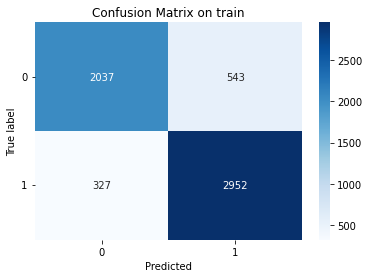

In [34]:
# Plot confusion matrix
cm = confusion_matrix(y_train_, pred_tweets_train)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on train")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

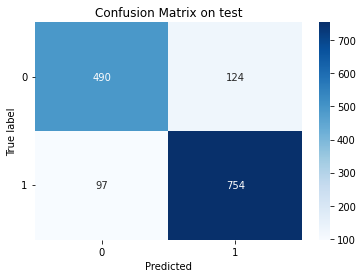

In [35]:
# Plot confusion matrix
cm = confusion_matrix(y_test, pred_tweets_test)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on test")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

# Inference

In [36]:
predictor.predict("Let's fraction the vital need for Our fatalities.  How would you break it down")

'not_disaster'

In [37]:
predictor.predict("How emotional are you that Ross is dead?")

'not_disaster'

In [38]:
predictor.predict('I Will Survive by Gloria Gaynor (with Oktaviana Devi)')

'not_disaster'